# Part 1

In [5]:
import pandas as pd

mdf = pd.read_csv('linked_mortality_file_1999_2000.csv') # Load mortality file
#print( mdf.head() )
gdf = pd.read_sas("DEMO.xpt", format="xport") # Load demographics file
#print( gdf.head() )
df = gdf.merge(mdf, on="SEQN", how="inner") # Merge mortality and demographics on SEQN variable

drug = pd.read_sas("DUQ.xpt", format="xport") # Load drug file
drugdf = drug.merge(df, on="SEQN", how="inner") # Merge drug and demographics/mortality on SEQN variable
print( drugdf.head() )


   SEQN  DUQ100        DUQ110  DUQ120  DUQ130  SDDSRVYR  RIDSTATR  RIDEXMON  \
0   5.0     2.0           NaN     NaN     NaN       1.0       2.0       2.0   
1   7.0     2.0           NaN     NaN     NaN       1.0       2.0       2.0   
2  10.0     2.0           NaN     NaN     NaN       1.0       2.0       2.0   
3  12.0     1.0  5.397605e-79     2.0     NaN       1.0       2.0       1.0   
4  15.0     2.0           NaN     NaN     NaN       1.0       2.0       1.0   

   RIAGENDR  RIDAGEYR  ...       WTIREP50       WTIREP51       WTIREP52  \
0       1.0      49.0  ...   92817.926915   94282.855382   91993.251203   
1       2.0      59.0  ...   22807.008623   23085.785591   23918.402495   
2       1.0      43.0  ...   21725.159674   21625.081706   22539.031224   
3       1.0      37.0  ...   94400.394199   95890.298459   93561.658462   
4       2.0      38.0  ...  110186.143135  112750.496899  110008.647960   

   ELIGSTAT  MORTSTAT  UCOD_LEADING  DIABETES  HYPERTEN  PERMTH_INT  \
0  

Variables Explained:

`ELIGSTAT`: Indicates eligibility status for mortality follow-up. A value of 1 indicates that the participant was eligible for mortality linkage. A value of 2 indicates that the participant was under 18 and not eligible for public release. A value of 3 indicates they were not linkage eligible due to insufficient identifying data to conduct data linkage. 

`MORTSTAT`: Indicates the determination of vital status. Each participant who is linkage eligible for mortality follow-up is assigned a vital status code (0 = Assumed alive, 1 = Assumed deceased based on NDI linkage, 2 = Assumed deceased from non-NDI source).

`PERMTH_INT`: Follow-up time that has been calculated using person months from the date of the interview to the date of death or end of the mortality period.

`RIDAGEEX`: Best age in months at date of examination for individuals under 85 years of age at screening.


The dataset we selected from NHANES 1999--2000 was Drug Use (DUQ.xpt). Our rationale for selecting this dataset is that many drugs often have potentially lethal side effects. 

In [16]:
# Proportion of missing values in each column of drugdf
drugdf.isna().mean().sort_values(ascending=False)

DMAETHN     1.00000
DMDSCHOL    1.00000
DMDEDUC3    1.00000
DMARACE     1.00000
DUQ130      0.98203
             ...   
WTMREP17    0.00000
WTMREP16    0.00000
WTMREP15    0.00000
WTMREP14    0.00000
WTMREP34    0.00000
Length: 155, dtype: float64

## EDA / Visualizations

In [24]:
# Setup and variable creation
import numpy as np
import matplotlib.pyplot as plt

# Restrict to mortality-eligible respondents
df = drugdf.copy()
df = df[df["ELIGSTAT"] == 1].copy()

# Create outcome variables
df["death"] = df["MORTSTAT"].isin([1, 2]).astype(int)
df["followup_months"] = df["PERMTH_INT"]

# Clean DUQ variables (replace refused/don’t know with NaN)
duq_vars = ["DUQ100","DUQ110","DUQ120","DUQ130"]
for v in duq_vars:
    if v in df.columns:
        df[v] = df[v].replace({7: np.nan, 9: np.nan})

# Create binary indicators
df["ever_drug_use"] = (df["DUQ100"] == 1).astype(float)
df["ever_needle_use"] = (df["DUQ120"] == 1).astype(float)

print("Sample size after eligibility restriction:", len(df))

Sample size after eligibility restriction: 2835


Death distribution (proportion):
death
0    0.893474
1    0.106526
Name: proportion, dtype: float64

Follow-up time summary:
count    2835.000000
mean      229.116402
std        36.691237
min         3.000000
25%       232.000000
50%       238.000000
75%       244.000000
max       250.000000
Name: followup_months, dtype: float64


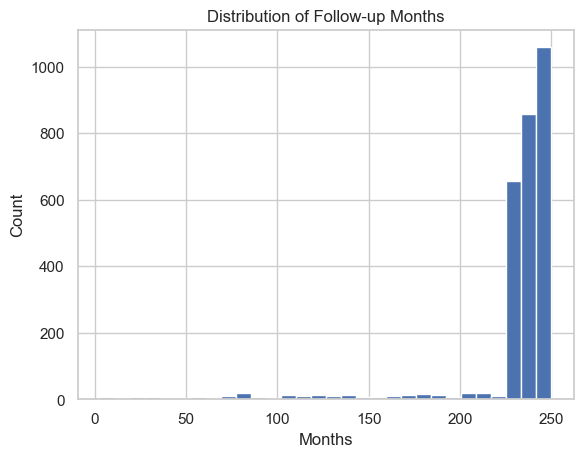

<Figure size 640x480 with 0 Axes>

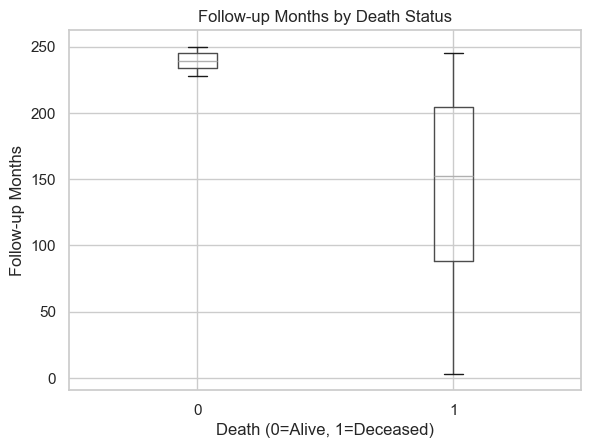

In [27]:
# Outcome Distribution (Mortality and Follow-up Time)

# Examine class balance for mortality outcome

# This shows the proportion of respondents who died (death=1) versus those still alive at end of follow-up (death=0).
# Important for understanding whether the classification problem is imbalanced.
print("Death distribution (proportion):")
print(df["death"].value_counts(normalize=True))

# Summary statistics for survival time (in months)

# Provides count, mean, median (50%), quartiles, min, and max.
print("\nFollow-up time summary:")
print(df["followup_months"].describe())

# Histogram of follow-up time

# Visualizes the distribution of survival time.
# Survival data are often right-skewed.
# Skewness may affect regression modeling choices.
plt.figure()
df["followup_months"].hist(bins=30)
plt.title("Distribution of Follow-up Months")
plt.xlabel("Months")
plt.ylabel("Count")
plt.show()

# Boxplot of follow-up time by death status

# Compares survival time between deceased and surviving respondents.
# Deceased individuals should generally show shorter follow-up times.
# This helps validate logical consistency of the mortality data.
plt.figure()
df.boxplot(column="followup_months", by="death")
plt.title("Follow-up Months by Death Status")
plt.suptitle("")  # removes automatic pandas subtitle
plt.xlabel("Death (0=Alive, 1=Deceased)")
plt.ylabel("Follow-up Months")
plt.show()